# Tidy Tuesday - Predicting boardgame ratings (Part 1)


In January 2022, the R Tidy Tuesday featured a dataset of boardgame ratings from BoardGameGeek.com. One of the fields in this dataset is the average rating of each boardgame, which is the average of the ratings (on a scale of 1 to 10) given by users of BoardGameGeek.com to the game in question. This notebook (combined with Part 2, to come) investigates whether a boardgame's average rating can be predicted using data on the characteristics of the game, such as the game's player count and playing time, the game mechanics involved in the game, the game's designer(s) and the game's publisher(s).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
ratings = pd.read_csv("ratings.csv")
details = pd.read_csv("details.csv")

For this exercise, we first randomly split the dataset into a training set, consisting of 80% of the boardgame entries, and a test set, consisting of the remaining 20%. The plots that follow will all be based on the training data.

In [3]:
training_data, test_data = train_test_split(ratings,
                                            shuffle = True,
                                            test_size = 0.2,
                                            random_state = 2023)

Before we start modeling (in part 2), let's have a quick run-through of the variables available in the dataset.

### The target variable

We will attempt to predict for each boardgame the variable entitled "average", which represents the average of BoardGameGeek.com users' ratings for the boardgame, on a scale of 1 to 10.

The plot below shows the distribution of ratings in the training data. As we see from the plot, the modal average boardgame rating is somewhere between 6 and 7, and a substantial majority of average ratings lie between 4 and 8.

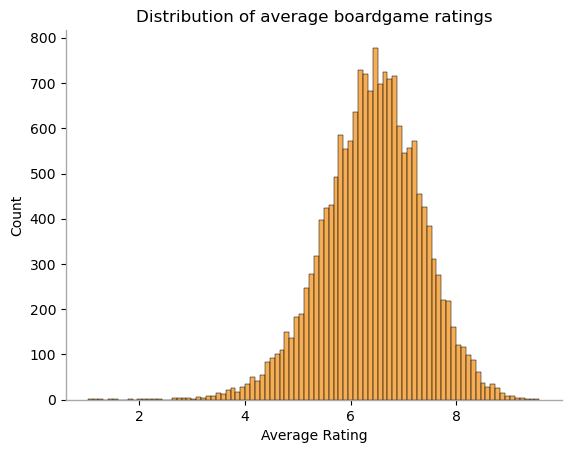

In [4]:
with mpl.rc_context({'grid.linestyle': ':',
                    'axes.facecolor': 'white',
                    'grid.color': 'lightgray',
                    'axes.spines.bottom': True,
                     'axes.spines.left' : True,
                     'axes.spines.top' : False,
                     'axes.spines.right' : False,
                    'axes.edgecolor': 'darkgray',
                    'axes.linewidth': 1.0}):
    p1 = sns.histplot(data = training_data, x = "average", color = "#F2921D").set(
        title = "Distribution of average boardgame ratings",
        xlabel = "Average Rating")


### Other variables

The dataset comes in two files, *ratings.csv* and *details.csv*. In both files, a row corresponds to a single boardgame, so the two files can easily be merged. The table below summarizes the number of observations in the training and test sets.

In [5]:
n_train_ratings = len(training_data)
n_test_ratings = len(test_data)

train_details = training_data.merge(details, on = "id")
n_train_w_details = len(train_details)
test_details = test_data.merge(details, on = "id")
n_test_w_details = len(test_details)

n_obs_table = pd.DataFrame({
    "Table" : ["Training (ratings)", "Training (details)", "Test (ratings)", "Test (details)"],
    "Number of observations": [n_train_ratings, n_train_w_details, n_test_ratings, n_test_w_details]
})
n_obs_table


,Table,Number of observations
0,Training (ratings),17464
1,Training (details),17311
2,Test (ratings),4367
3,Test (details),4320


In [6]:
train_details["test"] = 0
test_details["test"] = 1
combined_details = pd.concat([train_details, test_details], axis = 0)

Next, let's plot average rating as a function of various potential features (`yearpublished`, `minplayers`, `maxplayers`, `playingtime`, and designer, mechanic, and publisher variables).

### Number of players

We will treat the player-number features (minimum player count and maximum player count) as categorical, rather than numerical, since they are typically small and integer-valued.

The plot below shows the distribution of games by minimum player count (top panel), along with the distribution of average ratings by minimum player count (bottom panel). A minimum player count of 1 seems to be associated with higher average ratings than a minimum player count of 2: presumably players value the ability to play a game in "solo" mode.

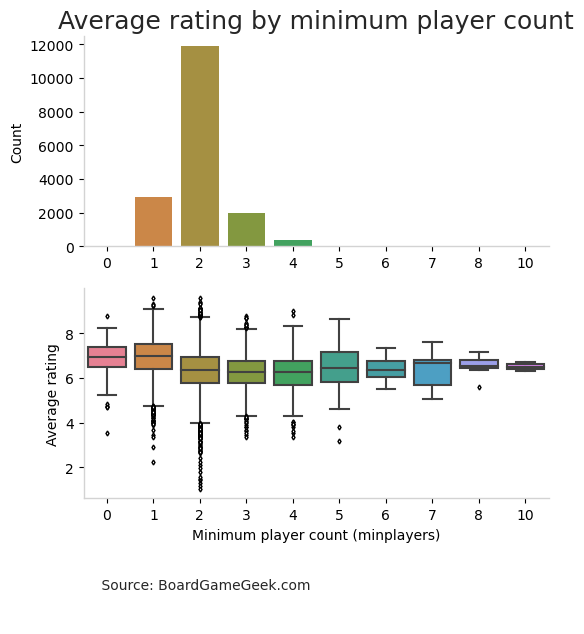

In [7]:

flierprops = dict(marker='d',
                  markerfacecolor='white',
                  markeredgecolor = 'black',
                  markersize=2.5)
palette = sns.color_palette("husl", 11)

with mpl.rc_context({'text.color': '.15',
                    'grid.linestyle': ':',
                    'axes.facecolor': 'white',
                    'grid.color': 'lightgray',
                    'axes.spines.bottom': True,
                     'axes.spines.left' : True,
                     'axes.spines.top' : False,
                     'axes.spines.right' : False,
                    'axes.edgecolor': 'lightgray',
                    'axes.linewidth': 1.0,
                    'axes.titlesize': 18,
                    'axes.titlecolor': '.15'}):
    fig, ax = plt.subplots(2, 1, figsize=(6, 6))
    ax = ax.flatten()
    
    p1 = sns.countplot(ax = ax[0], data = train_details, x = "minplayers",
                      palette = palette)
    p2 = sns.boxplot(ax = ax[1],
                     data = train_details,
                     x = "minplayers",
                     y = "average",
                     flierprops = flierprops,
                     palette = palette)
    temp = p1.set(title = "Average rating by minimum player count",
                  xlabel = "",
                  ylabel = "Count")
    temp = p2.set(title = "",
                  xlabel = "Minimum player count (minplayers)",
                  ylabel = "Average rating")

    footnote_text = f"""
    Source: BoardGameGeek.com
    
    """
    ax[1].annotate(footnote_text, xy = (0.0, -.3), xycoords = "axes fraction", ha = "left", va = "top")


The plot below shows the distribution of games by *maximum* player count (top panel), along with average ratings by maximum player count (bottom panel). Unsurprisingly, even-valued maximum player counts are more common than odd-valued max player counts. However, there seems to be a small premium associated with even max player counts: games with maximum player counts of 5 and 7 have slightly higher average ratings than games with maximum player counts of 4 and 6, respectively. It is unclear to me why this should be the case, but one possible explanation is that odd-valued maximum player counts, by virtue of being more unusual, are associated with more thoughtful game design, which results in higher average ratings.

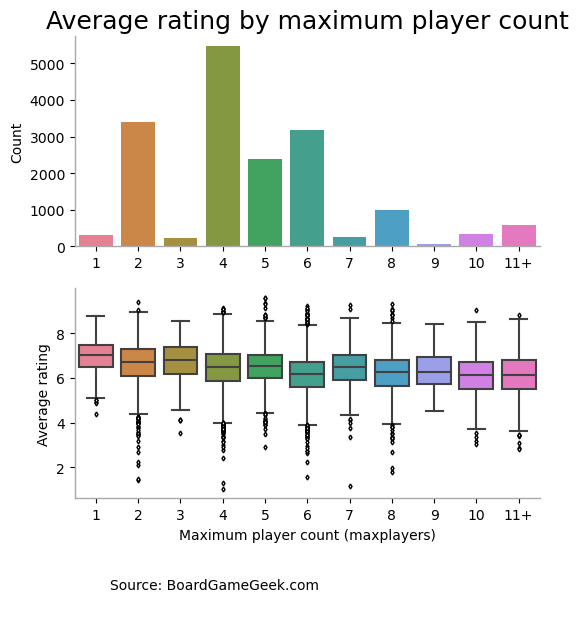

In [8]:
train_details_plot = train_details.copy()
train_details_plot["maxplayers"] = train_details["maxplayers"].apply(lambda x: str(x) if x <= 10 else "11+")

factor_order = [str(i) for i in range(1,11)] + ["11+"]

palette = sns.color_palette("husl", 11)

with mpl.rc_context({'grid.linestyle': ':',
                    'axes.facecolor': 'white',
                    'grid.color': 'lightgray',
                    'axes.spines.bottom': True,
                     'axes.spines.left' : True,
                     'axes.spines.top' : False,
                     'axes.spines.right' : False,
                    'axes.edgecolor': 'darkgray',
                    'axes.linewidth': 1.0,
                    'axes.titlesize': 18,
                    'axes.titlecolor': 'black'}):
    
    fig, ax = plt.subplots(2, 1, figsize=(6, 6))
    ax = ax.flatten()

    p1 = sns.countplot(ax = ax[0], data = train_details_plot, x = "maxplayers", order = factor_order, palette = palette)
    p2 = sns.boxplot(ax = ax[1], data = train_details_plot,
                     x = "maxplayers",
                     y = "average",
                     order = factor_order, 
                     palette = palette,
                    flierprops = flierprops)
    temp = p1.set(title = "Average rating by maximum player count", xlabel = "", ylabel = "Count")
    temp = p2.set(title = "", xlabel = "Maximum player count (maxplayers)", ylabel = "Average rating")
    
    footnote_text = f"""
        Source: BoardGameGeek.com

        """
    ax[1].annotate(footnote_text, xy = (0.0, -.3), xycoords = "axes fraction", ha = "left", va = "top")

### Playing time

Next, let's look at the playing time for each game.

The plot below shows the distribution of playing times, as well as the average rating by playing time. (Note that the bins below include their maximum values, e.g., the "0-30 mins" bin includes games with a reported playing time of 30 minutes exactly.)

The plot shows that that longer games have higher average ratings, on average. This is presumably not a direct causal effect, i.e., it is not the case that doubling a game's playing time will automatically make the game better. Rather, it is more likely, in my view, to reflect some combination of the following factors: (i) a longer playing time allows a game to be more complex and more complex games (at least up to a point) are better on average; and (ii) longer games are less accessible (on average) and therefore have a higher quality threshold they must exceed in order to get published, which results in an apparent association between longer games and higher quality.


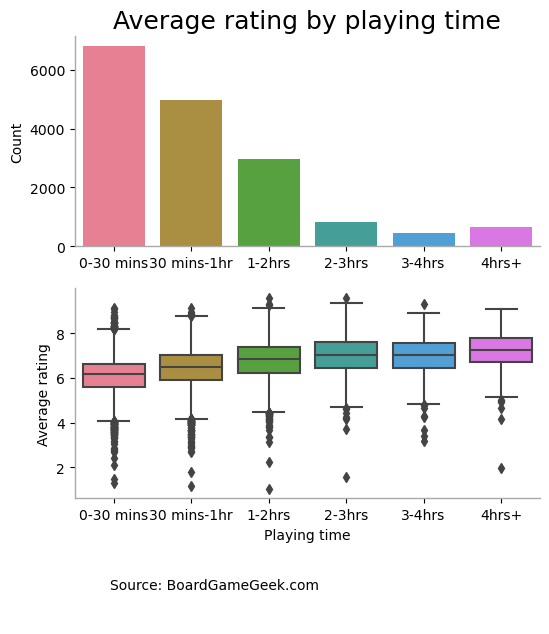

In [9]:
train_details_plot = train_details.copy()
train_details_plot["playingtime_binned"] = pd.cut(train_details_plot["playingtime"],
                                                 bins = [0, 30, 60, 120, 180, 240, np.inf],
                                                 labels = ["0-30 mins", "30 mins-1hr", "1-2hrs", "2-3hrs", "3-4hrs", "4hrs+"],
                                                 right = True)

with mpl.rc_context({'grid.linestyle': ':',
                    'axes.facecolor': 'white',
                    'grid.color': 'lightgray',
                    'axes.spines.bottom': True,
                     'axes.spines.left' : True,
                     'axes.spines.top' : False,
                     'axes.spines.right' : False,
                    'axes.edgecolor': 'darkgray',
                    'axes.linewidth': 1.0,
                    'axes.titlesize': 18,
                    'axes.titlecolor': 'black'}):
    fig, ax = plt.subplots(2, 1, figsize=(6, 6))
    ax = ax.flatten()

    p1 = sns.countplot(ax = ax[0], 
                  data = train_details_plot, 
                  x = "playingtime_binned", 
                  palette = sns.color_palette("husl", 6))
    p2 = sns.boxplot(ax = ax[1], 
                data = train_details_plot, 
                x = "playingtime_binned", 
                y = "average", 
                palette = sns.color_palette("husl", 6))
    temp = p1.set(title = "Average rating by playing time",
          xlabel = "", ylabel = "Count")
    temp = p2.set(title = "", xlabel = "Playing time", ylabel = "Average rating")
    
    footnote_text = f"""
        Source: BoardGameGeek.com

        """
    ax[1].annotate(footnote_text, xy = (0.0, -.3), xycoords = "axes fraction", ha = "left", va = "top")



### Year published

The plot below shows the distribution of boardgames by year of publication binned into 5-year periods (top panel), as well as the average rating by bin (bottom panel).

As the plot shows, more recent games tend to have higher ratings. This pattern should not necessarily be interpreted to mean that modern games are better in an objective sense than older games. That may be true, but the same pattern can also arise if modern games simply appeal more to *today's* reviewers, since the rating data reflects today's reviewers' preferences. The pattern may also reflect a preference for newness: if reviewers give higher scores to games that are new *to them*, for example, then more recently released games are likely to have higher ratings on average.

Incidentally, the plot also illustrates the explosion in boardgame publishing over the past 20 years or so. Over twice as many games were published in the years 2015-19 as were published in the entire 1990s.


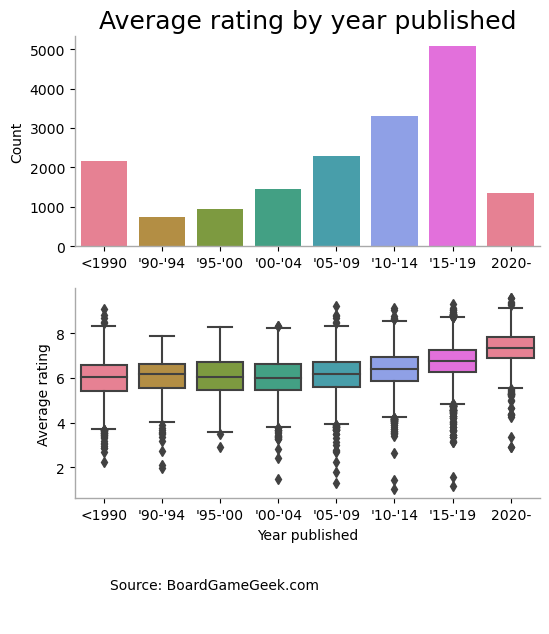

In [23]:

plot_data = train_details.copy()

plot_data["yearpublished_cat"] = pd.cut(plot_data["yearpublished"], right = False,
       bins = [-np.inf, 1990, 1995, 2000, 2005, 2010, 2015, 2020, np.inf],
       labels = ["<1990", "'90-'94", "'95-'00", "'00-'04", "'05-'09", "'10-'14", "'15-'19", "2020-"])

with mpl.rc_context({'grid.linestyle': ':',
                    'axes.facecolor': 'white',
                    'grid.color': 'lightgray',
                    'axes.spines.bottom': True,
                     'axes.spines.left' : True,
                     'axes.spines.top' : False,
                     'axes.spines.right' : False,
                    'axes.edgecolor': 'darkgray',
                    'axes.linewidth': 1.0,
                    'axes.titlesize': 18,
                    'axes.titlecolor': 'black'}):
    fig, ax = plt.subplots(2, 1, figsize=(6,6))
    ax = ax.flatten()

    p1 = sns.countplot(ax = ax[0], 
                  data = plot_data, 
                  x = "yearpublished_cat", 
                  palette = sns.color_palette("husl", 7))
    p2 = sns.boxplot(ax = ax[1],
                     data = plot_data,
                     x = "yearpublished_cat",
                     y = "average",
                     palette = sns.color_palette("husl", 7))
    temp = p1.set(title = "Average rating by year published",
          xlabel = "", ylabel = "Count")
    temp = p2.set(title = "", xlabel = "Year published", ylabel = "Average rating")
    
    footnote_text = f"""
        Source: BoardGameGeek.com

        """
    ax[1].annotate(footnote_text, xy = (0.0, -.3), xycoords = "axes fraction", ha = "left", va = "top")


### Mechanics, Designers, and Publishers

The dataset includes data on the game mechanics (e.g., "Dice rolling," "Auctions/Bidding") used in each boardgame. Each game can be associated with multiple mechanics, so values in the "mechanics" field in *details.csv* are comma-separated lists of mechanics, which we have to preprocess before plotting. There are 149 different unique mechanics in the dataset.

What constitutes a unique mechanic (and for any given mechanic, whether a board game uses that mechanic or not) is not entirely objective. The mechanics values in the dataset are populated by users of BoardGameGeek.com.

The plot below shows the average rating deviation for the 30 most commonly seen mechanics (ranked in descending order of average rating deviation), where a mechanic's "average rating deviation" is the difference between the mean average rating for games featuring that mechanic and the overall mean average rating. The plot shows that board games with certain mechanics have higher average ratings than the overall average rating, while board games with other mechanics have lower average ratings.

It is interesting to see the mechanics associated with higher and lower average ratings. Boardgame fans will recognize mechanics used by many popular modern games (e.g., worker placement, cooperative play) among the set of mechanics with positive rating deviations. Among the negative deviation mechanics are mechanics associated with older games: for example, "Roll / Spin and Move" is a staple mechanic of classic boardgames such as Monopoly, Snakes and Ladders, and The Game of Life, but is relatively less prevalent in modern games.

In [11]:
# split mechanics
import re

def split_out_column(df, col_name, prefix = "cat_", category_threshold = 0):

  def increment_cat_dict(s): # find all unique entries (and create a dict counting the number of games having each mechanic)
    if not isinstance(s, str):
      return

    if s[1] == "'": # entries are either of the ["xx", "yy", ...] or ['xx', 'yy', ...]
      s = re.sub('"', "", s)
      s = s.replace("\\", "") # ignore escaping
      categories = re.findall(r"'([^']+)'", s)
    else:
      s = re.sub("'", "", s)
      s = s.replace("\\", "")
      categories = re.findall(r'"([^"]+)"', s)
    

    for category in categories:  
      if category in cat_dict:
        cat_dict[category] += 1
      else:
        cat_dict[category] = 1

  cat_dict = {}
  df[col_name].apply(increment_cat_dict)

  # Add columns for each dict
  new_df = df.copy()
  for category in cat_dict:

    if cat_dict[category] > category_threshold:
      new_col_name = prefix + category
      new_df[new_col_name] = new_df[col_name].str.contains(category)
      new_df[new_col_name] = pd.to_numeric(new_df[new_col_name], errors = 'coerce', downcast = "integer")

  return new_df


In [12]:
train_details_mech = split_out_column(train_details, "boardgamemechanic", prefix = "mech_", category_threshold = 15)

/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

In [13]:
# find the most common mechanics
# find most common mechs
mech_cols = [x for x in train_details_mech.columns if x.startswith("mech_")]

mech_counts = {}
for col in mech_cols:
  total = train_details_mech[col].sum()
  mech_counts[col] = total

mech_counts_df = pd.DataFrame.from_dict(data = mech_counts, orient = "index", columns = ["count"]).sort_values("count", ascending = False)

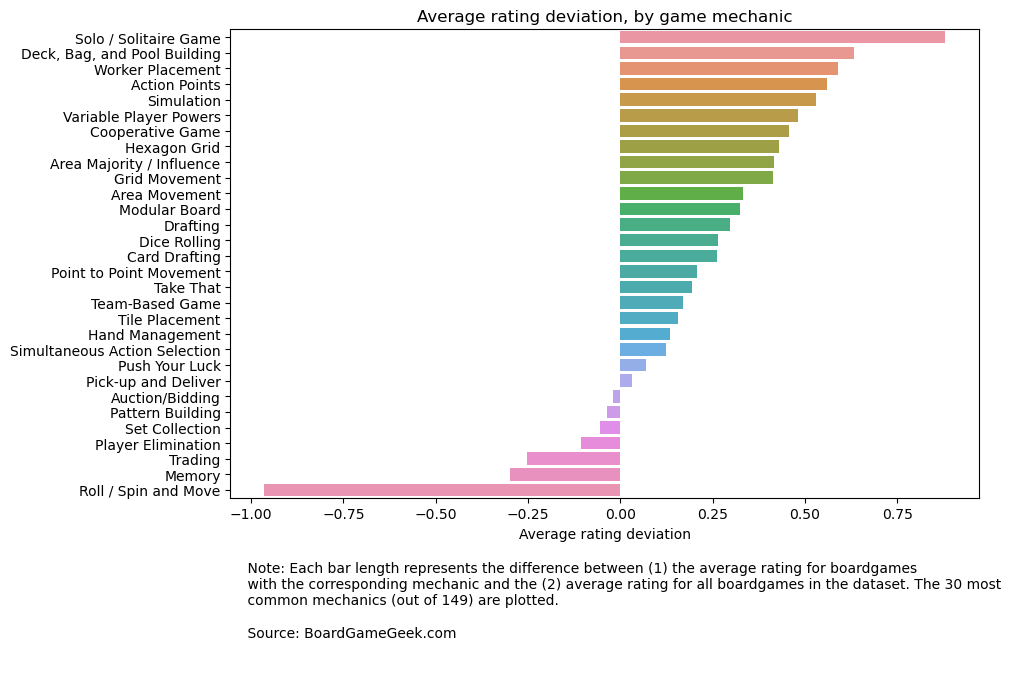

In [14]:
n_mechanics = len(mech_counts_df)

topX_mechs = mech_counts_df[:30]

all_groupbys = pd.DataFrame({"present":[],
                             "average":[],
                             "mech":[]})

overall_average = np.mean(train_details["average"])

for i, mech in enumerate(topX_mechs.index):
  mech = topX_mechs.index[i]
  mech_groupby = train_details_mech.groupby(mech).aggregate(np.mean)["average"].reset_index()
  mech_groupby["mech"] = mech
  mech_groupby = mech_groupby.rename(columns = {mech: "present"})
  all_groupbys = pd.concat([all_groupbys, mech_groupby], axis = 0)

all_groupbys = all_groupbys[all_groupbys["present"] == 1.0].drop(columns = "present")
all_groupbys["diff_average"] = all_groupbys["average"] - overall_average
all_groupbys["mech"] = all_groupbys["mech"].apply(lambda x: re.split("mech_", x)[1])
all_groupbys = all_groupbys.sort_values("diff_average", ascending = False)
#print(all_groupbys.sort_values("diff_average"))

fig, ax = plt.subplots(figsize = (10, 7))
p1 = sns.barplot(data = all_groupbys, y = "mech", x = "diff_average")
p1.set(title = "Average rating deviation, by game mechanic",
      xlabel = "Average rating deviation",
      ylabel = "")

footnote_text = f"""
    Note: Each bar length represents the difference between (1) the average rating for boardgames
    with the corresponding mechanic and the (2) average rating for all boardgames in the dataset. The 30 most 
    common mechanics (out of {n_mechanics}) are plotted.
    
    Source: BoardGameGeek.com
    
"""
ax.annotate(footnote_text, xy = (0.0, -.1), xycoords = "axes fraction", ha = "left", va = "top")
fig.tight_layout()

### Designers

We will treat designers as we did mechanics: a board game may have multiple designers, so we split out the "designer" variable, and create dummy variables indicating whether a board game was designed by a particular designer or not (whether by that designer alone or in conjunction with others). Because there are so many distinct designers in the dataset, we only include designers with at least 10 design credits.

The plot below shows the average rating deviation, by designer, for the twenty designers with the largest positive average rating deviations (among designers with at least 10 credits). For example, [Hermann Luttman](https://boardgamegeek.com/boardgamedesigner/36105/hermann-luttmann/linkeditems/boardgamedesigner?pageid=1), designer of 33 games, has a positive average rating deviation of almost 1.4 (out of 10).

In [15]:
train_details_designer = split_out_column(train_details,
                                          "boardgamedesigner",
                                          prefix = "dsgnr_",
                                          category_threshold = 10)

/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  new_df[new_col_name] = new_df[col_name].str.contains(category)
/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  new_df[new_col_name] = new_df[col_name].str.contains(category)
/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  new_df[new_col_name] = new_df[col_name].str.contains(category)
/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: UserWarning: This pattern is interpreted as a regular expression, and 

/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
/var/folders/h3/4l5s8cws6g9cglx2d1h2dml40000gn/T/ipykernel_6396/3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

In [16]:
designers = [x for x in train_details_designer if x.startswith("dsgnr_")]

all_groupbys = pd.DataFrame({"present":[],
                             "average":[],
                             "cat":[]})

overall_average = np.mean(train_details["average"])

for i, col_name in enumerate(designers):
  cat_groupby = train_details_designer.groupby(col_name).aggregate(np.mean)["average"].reset_index()
  cat_groupby["cat"] = col_name
  cat_groupby = cat_groupby.rename(columns = {col_name: "present"})
  
  #print(cat_groupby)

  all_groupbys = pd.concat([all_groupbys, cat_groupby], axis = 0)

all_groupbys = all_groupbys[all_groupbys["present"] == 1.0].drop(columns = "present")
all_groupbys["diff_average"] = all_groupbys["average"] - overall_average
all_groupbys["cat"] = all_groupbys["cat"].apply(lambda x: re.split("dsgnr_", x)[1])
all_groupbys = all_groupbys.sort_values("diff_average", ascending = False)



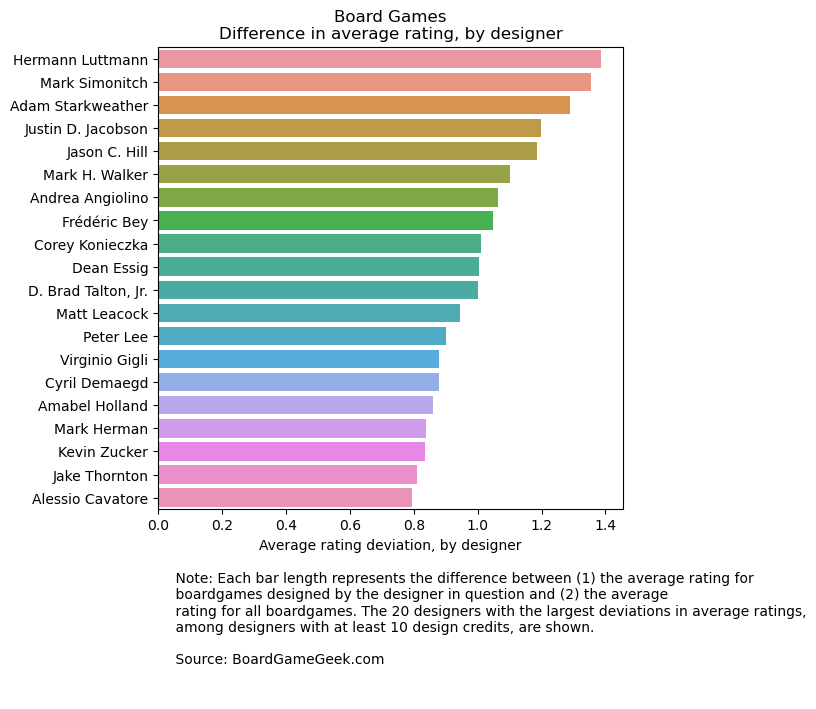

In [17]:
fig, ax = plt.subplots(figsize = (6, 6))
p1 = sns.barplot(data = all_groupbys[:20], y = "cat", x = "diff_average")
temp = p1.set(title = "Board Games\nDifference in average rating, by designer",
      xlabel = "Average rating deviation, by designer",
      ylabel = "")

footnote_text = f"""
    Note: Each bar length represents the difference between (1) the average rating for 
    boardgames designed by the designer in question and (2) the average 
    rating for all boardgames in the dataset. The 20 designers with the largest deviations 
    in average ratings among designers with at least 10 design credits are plotted.
    
    Source: BoardGameGeek.com
    
"""
temp = ax.annotate(footnote_text, xy = (0.0, -.1), xycoords = "axes fraction", ha = "left", va = "top")

### Publishers

With the "publisher" variable, we will take a different approach.

Using all the data we have on a boardgame's publisher in our modeling step risks contaminating the predictive analysis. This is because we are interested in predicting a boardgame's average rating based on intrinsic characteristics of the game and, unfortunately for us, the set of publishers associated with a game is not an intrinsic characteristic of the game. Rather, the set of publishers associated with a game is *endogenous* to the game's quality and eventual success in the marketplace, since more successful games are more likely to be published multiple times (via, for example, revised editions and other-language editions) and thus are likely to have a greater number of associated publishers.

One possible approach to deal with this endogeneity problem would be to use data on a boardgame's *first* publisher only, since the first publisher associated with a board game is far less likely to be influenced by a board game's eventual success than subsequent publishers. However, while the *boardgamepublisher* variable provides a list of publishers, it does not provide an apparent way to identify a game's first publisher. So instead, we randomly select one publisher per game for use in our analysis. This addresses the concern that the *number* of publishers associated with a game is endogenous to its quality, but it does not entirely eliminate the endogeneity concern.

Because there are far too many publishers in the dataset to deal with, for modeling and visualization, we will only retain publishers associated with at least 10 boardgames.

In [18]:
def reduce_multiple_entries(x):
  if not isinstance(x, str) or len(x) < 3:
    return ""

  if x[1] == "'":
    entries = re.findall(r"'([^']+)'", x)
  else:
    entries = re.findall(r'"([^"]+)"', x)
  
  if len(entries):
    return entries[np.random.randint(len(entries))] # if many, return random
  else:
    print(x)
    return ""

def clean_and_otherize_list_entry(s, threshold):
  # first reduce multiples
  s_new = s.apply(reduce_multiple_entries)

  # otherize publishers with < theshold entries
  s_counts = s_new.value_counts()
  small_entries = s_counts[s_counts < threshold].index.array
  s_new = s_new.apply(lambda x: "Other" if x in small_entries else x)

  return s_new

In [19]:
publisher_threshold = 10

publisher_clean = clean_and_otherize_list_entry(train_details["boardgamepublisher"], publisher_threshold)

#print(publisher_clean.value_counts()) # 313 distinct publishers

train_details_pub = train_details.copy()
train_details_pub["publisher_clean"] = publisher_clean

In [20]:
top_30_publishers = publisher_clean.value_counts()[:30].index.values

plot_data = train_details_pub[train_details_pub["publisher_clean"].isin(top_30_publishers)]





In [21]:
by_pub = plot_data.groupby(["publisher_clean"])["average"].agg(np.mean)
by_pub = by_pub.sort_values(ascending = False)
factor_order = by_pub.index


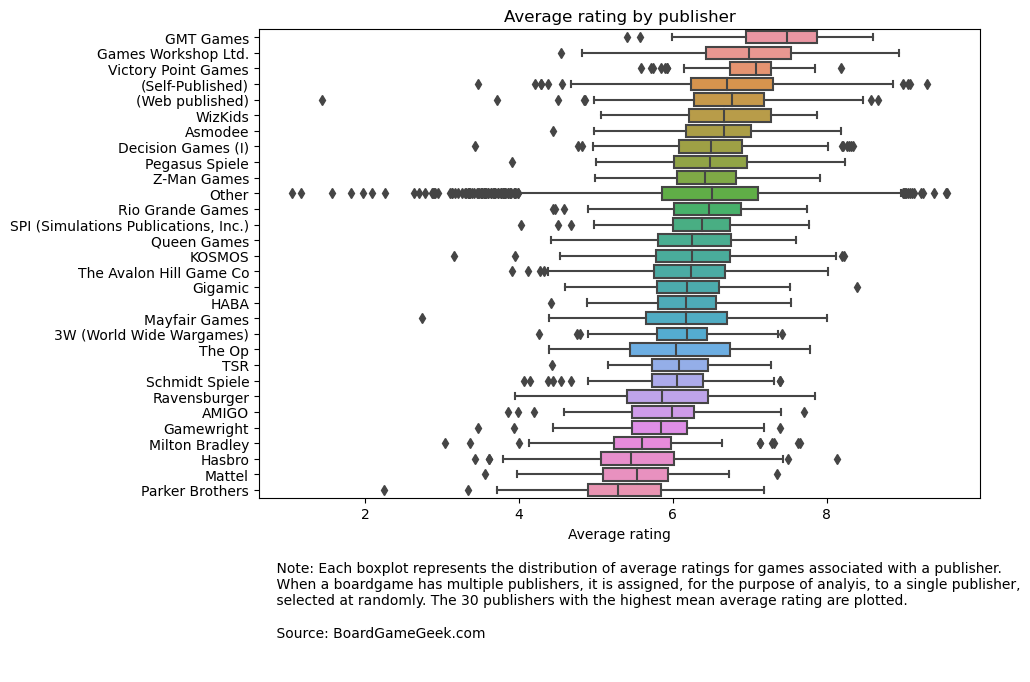

In [22]:

fig, ax = plt.subplots(figsize = (10, 7))


#p1 = sns.histplot(data = plot_data[plot_data["publisher_clean"] != "Other"], y = "publisher_clean")
p1 = sns.boxplot(data = plot_data, y = "publisher_clean", x = "average", order = factor_order)
temp = p1.set(title = "Average rating by publisher",
      xlabel = "Average rating",
      ylabel = "")

footnote_text = f"""
    Note: Each boxplot represents the distribution of average ratings for games associated with a publisher. 
    When a boardgame has multiple publishers, it is assigned to a single publisher, selected at random. 
    The 30 publishers with the highest mean average rating are plotted.
    
    Source: BoardGameGeek.com
    
"""
temp = ax.annotate(footnote_text, xy = (0.0, -.1), xycoords = "axes fraction", ha = "left", va = "top")
fig.tight_layout()

### Conclusion

Based on our visualizations, it seems that at least some of these features will help us predict average ratings. We will continue with the modeling in the Part 2.